## Import essential libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob

## Mount drive to import dataset and YOLO model weights

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
from IPython.display import clear_output, display, Image

## Install ```ultralytics``` library

In [ ]:
!pip install ultralytics
clear_output()

## Install ```PaddleOCR``` library for OCR operation

In [ ]:
!python -m pip install paddlepaddle -i https://pypi.tuna.tsinghua.edu.cn/simple
clear_output()

In [ ]:
!pip install "paddleocr>=2.0.1" # Recommend to use version 2.0.1+
clear_output()

## Unzip YOLO model weights

In [ ]:
!unzip -xq '.../odometer_detection_model.zip'

In [ ]:
from ultralytics import YOLO

yolov8_model = YOLO("/content/content/runs/detect/train/weights/best.pt")

## Do odometer detection using YOLO

In this part, I used the YOLO model to detect the odometer part from images and then crop and save the image.

In [ ]:
val_dir = '.../images/val'
images = sorted(glob(val_dir+'/*'))

if os.path.exists('odometers'):
  os.makedirs('odometers')

for image in images:
  result = yolov8_model.predict(source=image, conf=0.25, stream=False)
  result[0].save_crop(f"/content/odometers/{image.split('/')[-1].split('.')[0]}")

## OCR operation

### Do operation on 1 image

In [ ]:
!paddleocr --image_dir ./odometers/06c0c8f4-5496-4c4f-8dd4-1ed6c776763f/odometer/im.jpg.jpg --use_angle_cls true --lang en --use_gpu false

[2024/05/26 10:50:06] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir='./odometers/06c0c8f4-5496-4c4f-8dd4-1ed6c776763f/odometer/im.jpg.jpg', page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 4

First of all, we need to do some preprocessing on images. And after that feed this image to OCR model. I used Paddle OCR library.

In [ ]:
def preprocess(image_path):
    croped_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image to a larger size
    resized_image = cv2.resize(croped_image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(resized_image, (5, 5), 0)

    # Apply adaptive thresholding to enhance text
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply sharpening filter
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(binary, -1, kernel)

    # Increase contrast
    alpha = 2.0  # Simple contrast control
    beta = 0     # Simple brightness control
    contrasted = cv2.convertScaleAbs(sharpened, alpha=alpha, beta=beta)

    return contrasted

In [ ]:
cv2.imwrite('processed_img.jpg', preprocess('/content/odometers/06c0c8f4-5496-4c4f-8dd4-1ed6c776763f/odometer/im.jpg.jpg'))

True

In [ ]:
!paddleocr --image_dir ./processed_img.jpg --use_angle_cls true --lang en --use_gpu false

[2024/05/26 10:52:10] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir='./processed_img.jpg', page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec

## Do detection and plot the results

In [ ]:
!mkdir paddle_ocr

[2024/05/26 08:23:57] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='

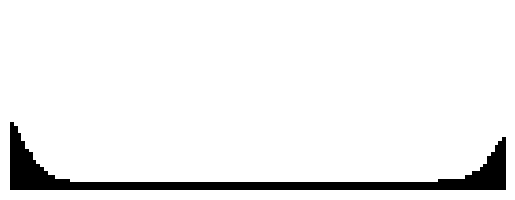

/content/odometers/0caa5ccf-61be-4111-a75d-9285c9956b58/odometer/im.jpg.jpg
[2024/05/26 08:24:02] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.05257058143615723
[2024/05/26 08:24:02] ppocr DEBUG: cls num  : 1, elapsed : 0.03846883773803711
[2024/05/26 08:24:02] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08652305603027344
[[[[15.0, 17.0], [94.0, 17.0], [94.0, 38.0], [15.0, 38.0]], ('79090.', 0.874281644821167)]]


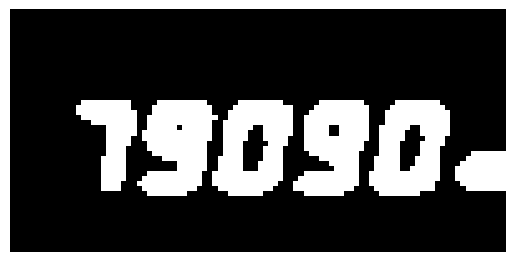

/content/odometers/1aeb3991-9a35-4823-b2e3-339b1e6dd53b/odometer/im.jpg.jpg
[2024/05/26 08:24:02] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0210421085357666
[2024/05/26 08:24:02] ppocr DEBUG: cls num  : 1, elapsed : 0.013552427291870117
[2024/05/26 08:24:02] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0635225772857666
[[[[12.0, 17.0], [98.0, 17.0], [98.0, 39.0], [12.0, 39.0]], ('58240.', 0.9328845143318176)]]


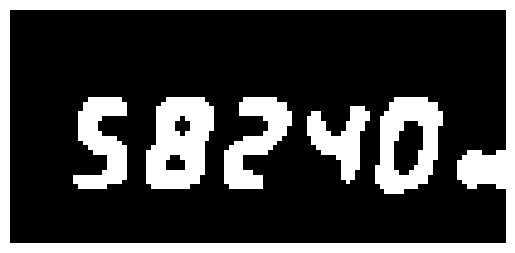

/content/odometers/1c6142f6-5eb2-43d8-a347-78d4c6156a27/odometer/im.jpg.jpg
[2024/05/26 08:24:02] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.04571676254272461
[2024/05/26 08:24:02] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/05/26 08:24:02] ppocr DEBUG: rec_res num  : 0, elapsed : 2.1457672119140625e-06
None


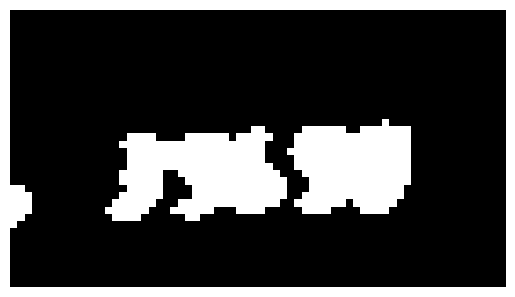

/content/odometers/2ce7942a-399f-44e9-a42d-8a2e220b10ec/odometer/im.jpg.jpg
[2024/05/26 08:24:02] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.06474971771240234
[2024/05/26 08:24:02] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/05/26 08:24:02] ppocr DEBUG: rec_res num  : 0, elapsed : 2.384185791015625e-06
None


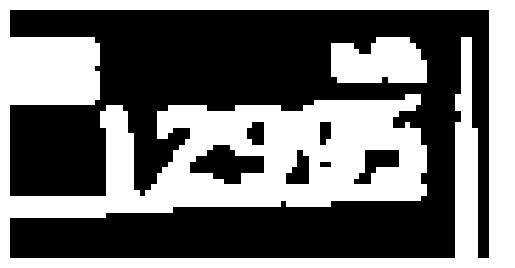

/content/odometers/3aece9a1-1dce-4de2-9f1a-80d3c81c43bd/odometer/im.jpg.jpg
[2024/05/26 08:24:03] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.017874479293823242
[2024/05/26 08:24:03] ppocr DEBUG: cls num  : 2, elapsed : 0.03844022750854492
[2024/05/26 08:24:03] ppocr DEBUG: rec_res num  : 2, elapsed : 0.12274742126464844
[[[[37.0, 0.0], [102.0, 0.0], [102.0, 16.0], [37.0, 16.0]], ('F6', 0.5881154537200928)], [[[14.0, 15.0], [94.0, 18.0], [92.0, 39.0], [13.0, 36.0]], ('02$804', 0.9167389273643494)]]


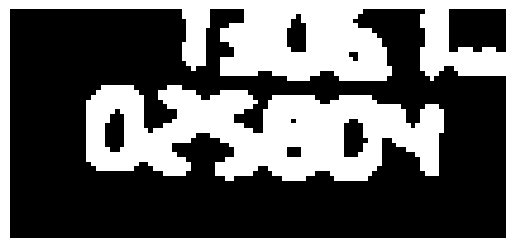

/content/odometers/3be914c3-8fe1-4486-82a5-c8a6c16b19cb/odometer/im.jpg.jpg
[2024/05/26 08:24:03] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.014858484268188477
[2024/05/26 08:24:03] ppocr DEBUG: cls num  : 1, elapsed : 0.013385772705078125
[2024/05/26 08:24:03] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05885028839111328
None


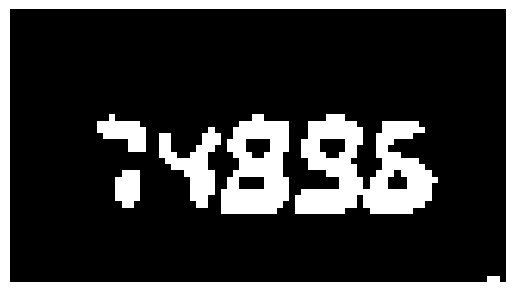

/content/odometers/3c3fde66-9bb3-4abc-8841-5bd604800e0d/odometer/im.jpg.jpg
[2024/05/26 08:24:03] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.016841650009155273
[2024/05/26 08:24:04] ppocr DEBUG: cls num  : 1, elapsed : 0.017533302307128906
[2024/05/26 08:24:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.08176541328430176
[[[[8.0, 17.0], [123.0, 15.0], [123.0, 42.0], [8.0, 44.0]], ('239295', 0.9701142311096191)]]


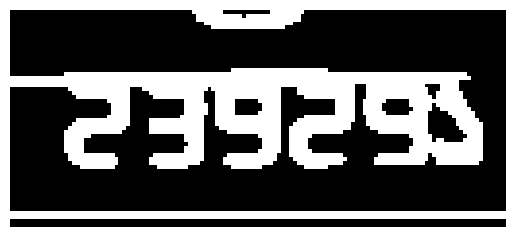

/content/odometers/3eba9e92-1193-46a3-9e9a-fbe1302d0ace/odometer/im.jpg.jpg
[2024/05/26 08:24:05] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.10904240608215332
[2024/05/26 08:24:06] ppocr DEBUG: cls num  : 1, elapsed : 0.012094736099243164
[2024/05/26 08:24:06] ppocr DEBUG: rec_res num  : 1, elapsed : 0.056234121322631836
[[[[20.0, 31.0], [225.0, 27.0], [226.0, 80.0], [21.0, 84.0]], ('*82E6E', 0.8767159581184387)]]


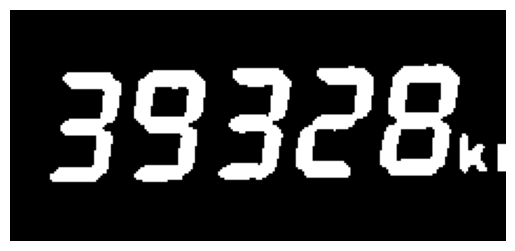

/content/odometers/4aa4e0ae-4393-4353-9590-9ea8b9907c9b/odometer/im.jpg2.jpg
[2024/05/26 08:24:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07894349098205566
[2024/05/26 08:24:07] ppocr DEBUG: cls num  : 1, elapsed : 0.010524749755859375
[2024/05/26 08:24:07] ppocr DEBUG: rec_res num  : 1, elapsed : 0.06381607055664062
[[[[28.0, 31.0], [242.0, 34.0], [240.0, 104.0], [26.0, 100.0]], ('hB5l l', 0.6959729790687561)]]


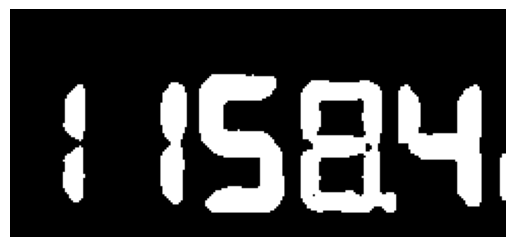

/content/odometers/4aa4e0ae-4393-4353-9590-9ea8b9907c9b/odometer/im.jpg.jpg
[2024/05/26 08:24:07] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07374024391174316
[2024/05/26 08:24:07] ppocr DEBUG: cls num  : 2, elapsed : 0.01206064224243164
[2024/05/26 08:24:07] ppocr DEBUG: rec_res num  : 2, elapsed : 0.08728432655334473
[[[[4.0, 27.0], [322.0, 29.0], [322.0, 96.0], [4.0, 94.0]], ('057803', 0.999703586101532)]]


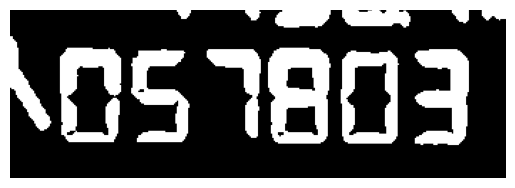

/content/odometers/4d7edd76-69bf-493a-827d-c610c629e655/odometer/im.jpg.jpg
[2024/05/26 08:24:07] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.02780318260192871
[2024/05/26 08:24:07] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/05/26 08:24:07] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06
None


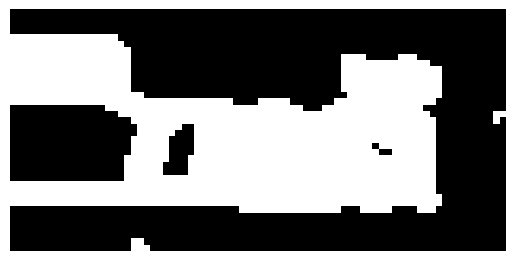

/content/odometers/5a13663a-984e-46b1-bd06-0948eb2f618f/odometer/im.jpg.jpg
[2024/05/26 08:24:07] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.017163753509521484
[2024/05/26 08:24:07] ppocr DEBUG: cls num  : 1, elapsed : 0.011489629745483398
[2024/05/26 08:24:08] ppocr DEBUG: rec_res num  : 1, elapsed : 0.056206464767456055
[[[[8.0, 17.0], [123.0, 15.0], [123.0, 42.0], [8.0, 44.0]], ('239295', 0.9701142311096191)]]


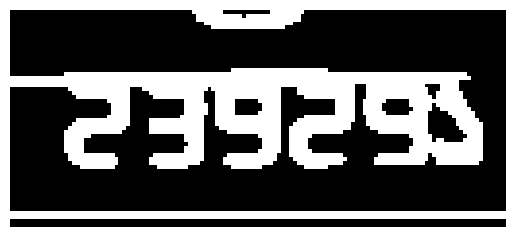

/content/odometers/5aec05a3-54de-4026-8d60-548a45d4692e/odometer/im.jpg.jpg
[2024/05/26 08:24:08] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.018217086791992188
[2024/05/26 08:24:08] ppocr DEBUG: cls num  : 3, elapsed : 0.04574775695800781
[2024/05/26 08:24:08] ppocr DEBUG: rec_res num  : 3, elapsed : 0.17000317573547363
[[[[3.0, 13.0], [122.0, 19.0], [120.0, 46.0], [0.0, 40.0]], ('112193', 0.9394318461418152)]]


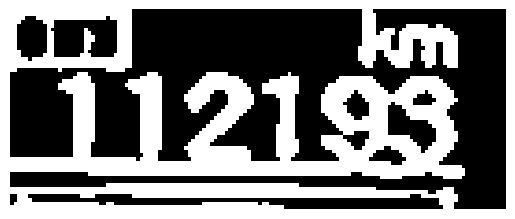

/content/odometers/6b73625d-fa33-4ec6-9f53-194432580e5f/odometer/im.jpg.jpg
[2024/05/26 08:24:08] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.032540082931518555
[2024/05/26 08:24:08] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/05/26 08:24:08] ppocr DEBUG: rec_res num  : 0, elapsed : 1.9073486328125e-06
None


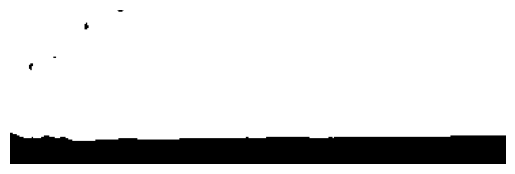

/content/odometers/6fd61537-ab8e-477e-9846-fd6e9b44243f/odometer/im.jpg.jpg
[2024/05/26 08:24:08] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.017803668975830078
[2024/05/26 08:24:08] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/05/26 08:24:08] ppocr DEBUG: rec_res num  : 0, elapsed : 3.337860107421875e-06
None


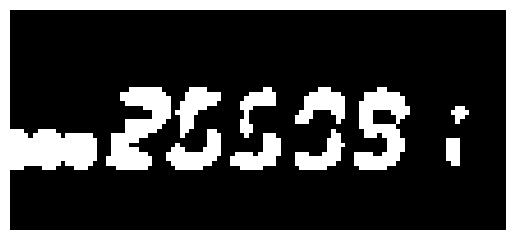

In [ ]:
from paddleocr import PaddleOCR,draw_ocr

ocr = PaddleOCR(use_angle_cls=True, lang='en')
for dir in sorted(glob('/content/odometers/*')):
  for img in os.listdir(f'{dir}/odometer'):
    contrasted = preprocess(os.path.join(dir, 'odometer', img))
    plt.imshow(contrasted, cmap='gray')
    cv2.imwrite(f"/content/paddle_ocr{dir.split('/')[-1]}.jpg", contrasted)
    result = ocr.ocr(f"/content/paddle_ocr{dir.split('/')[-1]}.jpg", cls=True, )
    print(result[0])
    plt.axis('off')
    plt.show()